# Introduction

## Domain-specific area

The domain is epidemiology, namely current Covid-19 pandemic, restricted in scope to a single country - Ukraine. Vaccination campaign in Ukraine started later than in other European countries and has been accompanied by a number of controversies which  eventually led to resignation of the local Health Minister[1][2]. Ukraine is large country with population over 40 million (roughly 5% of European population) and a source of thousands of seasonal migrant workers in EU; epidemiological situation in this country is critical to the epidemiological situation in Europe overall.

## Dataset

Dataset used in this research is "A global database of COVID-19 vaccinations"[3] available at https://ourworldindata.org under Creative Commons license.

The dataset contains data about COVID-19 dynamics (cases, deaths, vaccinations) per territory per day starting with 2020-02-24.

In [1]:
import pandas as pd
df = pd.read_csv('dataset.csv',parse_dates=['date'])

Number of rows

In [2]:
df.count()[0]

95066

Number of columns

In [3]:
len(df.columns)

60

Columns and types

In [4]:
df.dtypes

iso_code                                         object
continent                                        object
location                                         object
date                                     datetime64[ns]
total_cases                                     float64
new_cases                                       float64
new_cases_smoothed                              float64
total_deaths                                    float64
new_deaths                                      float64
new_deaths_smoothed                             float64
total_cases_per_million                         float64
new_cases_per_million                           float64
new_cases_smoothed_per_million                  float64
total_deaths_per_million                        float64
new_deaths_per_million                          float64
new_deaths_smoothed_per_million                 float64
reproduction_rate                               float64
icu_patients                                    

## Objectives

With this research we would like to answer the question "When is epedimic over?" in application to a specific country which is Ukraine. Epidemic may be considered to come to an end when the population reaches a specific level of herd immunity through vaccination and through recovering from the desease. The exact level of herd immunity is debatable and for this research we will assume it to be 70% of the total population.[4]

Despite COVID-19 being an everyday topic discussed in the media, we failed to find estimates about the duration of the epidemic in Ukraine with vaccination taken into account. 

# Implementation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from math import floor

#### Preprocess the data

Filter dataset to only include Ukaine and only year 2021 and restrict columns to the ones required for this research

In [6]:
selected_columns = ['date','total_cases', 'total_deaths', 'people_fully_vaccinated', 'population']
df = df.loc[(df['iso_code'] == 'UKR') & (df['date']>'2021-01-01')][selected_columns]
df.reset_index(drop=True,inplace=True)

##### Clean data of NaN values

In [7]:
df[df.isnull().any(axis=1)]

,date,total_cases,total_deaths,people_fully_vaccinated,population
0,2021-01-02,1102256.0,19498.0,NaN,43733759.0
1,2021-01-03,1107137.0,19630.0,NaN,43733759.0
2,2021-01-04,1111631.0,19712.0,NaN,43733759.0
3,2021-01-05,1117256.0,19929.0,NaN,43733759.0
4,2021-01-06,1124482.0,20171.0,NaN,43733759.0
...,...,...,...,...,...
83,2021-03-26,1665001.0,33068.0,NaN,43733759.0
84,2021-03-27,1682527.0,33363.0,NaN,43733759.0
91,2021-04-03,1783169.0,35729.0,NaN,43733759.0
112,2021-04-24,2071142.0,43884.0,NaN,43733759.0


It is correct to replace NaN in people_fully_vaccinated column with 0.

In [8]:
df['people_fully_vaccinated'] = df['people_fully_vaccinated'].fillna(0)

Check if we have more nulls

In [9]:
df[df.isnull().any(axis=1)]

,date,total_cases,total_deaths,people_fully_vaccinated,population


##### Add more columns

Add days_count columns which is integer representation of timescale required futher for regression calculaiton

In [10]:
df['days_count'] = (df['date'] - df['date'][0]) / np.timedelta64(1, 'D')

Add total_infected column which shows population who aquire immunity through recovary from the infection

In [11]:
df['total_infected'] = df['total_cases'] - df['total_deaths']

Add total_immunized column which is total population acquired immunity either though vaccination or infection

In [12]:
df['total_immunized'] = df['total_infected'] + df['people_fully_vaccinated']

##### Calculate target value

Assumed target value to reach the herd immunity is 70% which in absolute amount is

In [13]:
target_value = floor(df['population'][0] * 0.7)
target_value

30613631

#### Statistical summary

In [14]:
df.describe()

,total_cases,total_deaths,people_fully_vaccinated,population,days_count,total_infected,total_immunized
count,1.610000e+02,161.000000,161.000000,161.0,161.000000,1.610000e+02,1.610000e+02
mean,1.692101e+06,35153.757764,19611.229814,43733759.0,80.000000,1.656947e+06,1.676558e+06
std,4.100382e+05,11261.944584,47909.067790,0.0,46.620811,3.988427e+05,4.279297e+05
min,1.102256e+06,19498.000000,0.000000,43733759.0,0.000000,1.082758e+06,1.082758e+06
25%,1.302811e+06,25330.000000,0.000000,43733759.0,40.000000,1.277481e+06,1.277481e+06
50%,1.615747e+06,32018.000000,0.000000,43733759.0,80.000000,1.583729e+06,1.583730e+06
75%,2.137959e+06,46447.000000,290.000000,43733759.0,120.000000,2.091512e+06,2.091802e+06
max,2.281303e+06,53683.000000,230420.000000,43733759.0,160.000000,2.227620e+06,2.458040e+06


Even though we can retrieve these summarized data, it does not provide much value to us. Objective of this research involves working with cumulative data over time. If we were to work with daily data then such measures could be of more interest.

As far as we are dealing with cumulative data, it is likely that distribution is going to be some type of  F cumulative distribution[5]. Example for total cases over time is on the plot below.

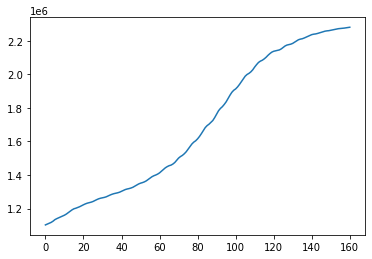

In [15]:
plt.plot(df['days_count'],df['total_cases'])
plt.show()

Distribution for people_fully_vaccinated starts as uniform and starts to develop and upward trend at about day 130.

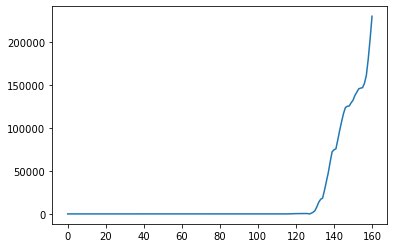

In [16]:
plt.plot(df['days_count'],df['people_fully_vaccinated'])
plt.show()

In [17]:
people_fully_vaccinated_day_start = 130

#### Visualization

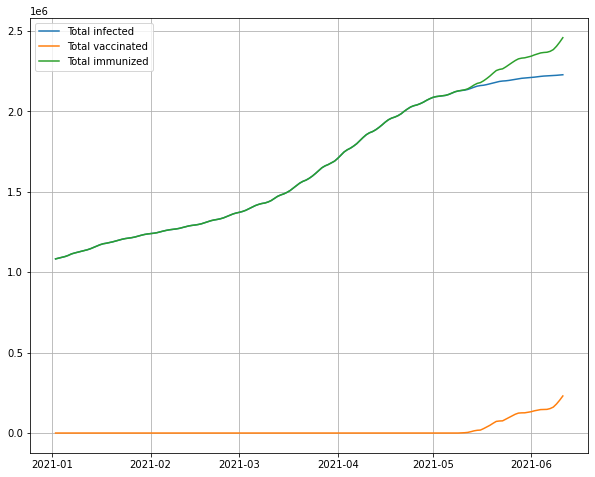

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

one_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(one_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.plot(df['date'],df['total_infected'], label='Total infected')
ax.plot(df['date'],df['people_fully_vaccinated'], label='Total vaccinated')
ax.plot(df['date'],df['total_immunized'], label='Total immunized')
ax.grid(True)
ax.legend()
plt.show()

##### Create a model

In [19]:
model = LinearRegression(fit_intercept=True)

Visualizing progression of vaccination and total cases

In [20]:
def plot_regression_results(days,show_total_immunized=False, show_target_ticks=False):
    #### Calculating total infected progression
    x = df['days_count'].values
    y = df['total_infected'].values

    X = x[:, np.newaxis]
    model.fit(X,y)

    xfit = np.linspace(-1,days)
    Xfit = xfit[:, np.newaxis]
    yfit = model.predict(Xfit)

    #### Calculating total vaccinated progression
    x1 = df.loc[(df['days_count'] > people_fully_vaccinated_day_start)]['days_count'].values
    y1 = df.loc[(df['days_count'] > people_fully_vaccinated_day_start)]['people_fully_vaccinated'].values

    X1 = x1[:, np.newaxis]
    model.fit(X1,y1)

    x1fit = np.linspace(-1,days)
    X1fit = x1fit[:, np.newaxis]
    y1fit = model.predict(X1fit)

    ##Convert days count into date time
    base = df['date'][0]
    dates_total = np.array([base + datetime.timedelta(days=i) for i in xfit])
    dates_x = np.array([base + datetime.timedelta(days=i) for i in x])
    dates_x1 = np.array([base + datetime.timedelta(days=i) for i in x1])
    dates_y1 = dates_total
    
    #plot value
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    ax.plot(dates_x, y, label='Total infected actual')
    ax.plot(dates_x1, y1, label='Total vaccinated actual')
    ax.plot(dates_total,yfit, label='Total infected projected')
    ax.plot(dates_total,y1fit, label='Total vaccinated projected')
    if(show_total_immunized):
        ax.plot(dates_total,yfit + y1fit, label='Total immunized projected') 
    if(show_target_ticks):
        ax.axhline(target_value, linestyle='--', color='r')
        ax.set_yticks([x for x in range(0,int(df['population'][0])) if x % 1000000 == 0], minor=True)
        ax.yaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='minor',linestyle='--')
    ax.legend()
    ax.grid(True)
    plt.show()

From the plot below we can see that projection of total infected population corresponds to real data quite well: there are some local deviations (prediction may be higher than actual data or lower) but these deviations are mutually conpensatable and over time predicted values stay quite close to the actual data.

Total vaccinated projection, on the cotrary, corresponds the actual data quite bad. There is much less data to build a quality projection. From what we can see on the screen, the projection may be quite pessimistic.

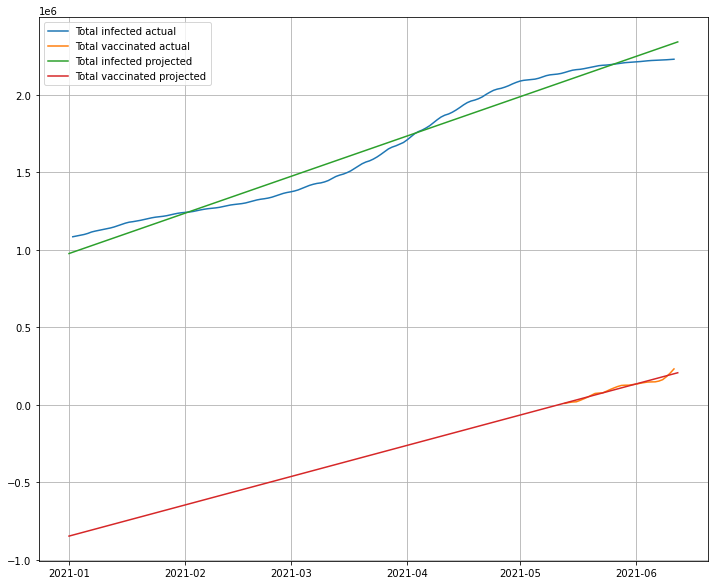

In [21]:
plot_regression_results(df['days_count'].count(), show_total_immunized=False, show_target_ticks=False)

How much days since 2021-01-01 to wait to reach 70% population immunized without vaccine

In [22]:
x = df['total_infected'].values
y = df['days_count'].values

X = x[:, np.newaxis]
model.fit(X,y)

target_days = floor(model.predict(np.array(target_value).reshape(-1,1)))
#days since 2021-01-01 to reach herd immunity
print(target_days)
print(df['date'][0] + datetime.timedelta(days=target_days))

3412
2030-05-07 00:00:00


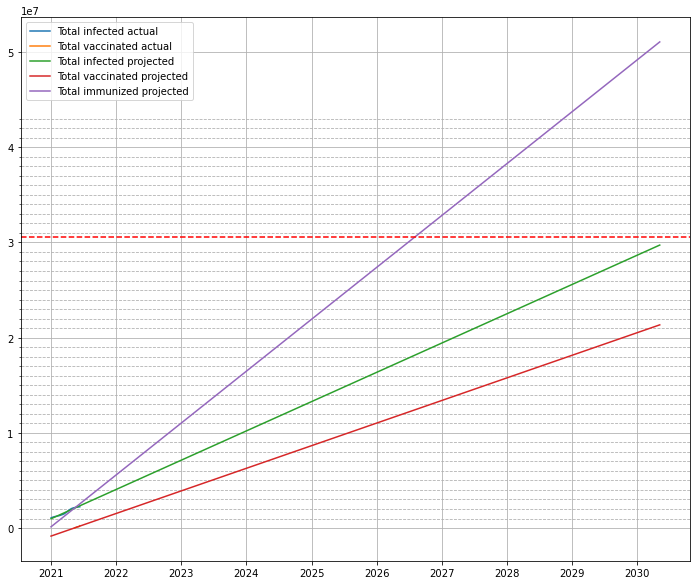

In [23]:
plot_regression_results(target_days, show_total_immunized=True, show_target_ticks=True)

The project date of acheiving herd immunity without vaccination is May 2030, the projected date of acheiving herd immunity with vaccination at the current rate is around May 2026 as visible from the plot above. We can also see that the number of vaccinated in May 2026 is projected to be about 12 m while number of total infected is 18 m.

# Conclusions

## Results of the ML model

Information about metrics and scoring for regression models is available at Scikit-learn  website.[6]

In [24]:
from sklearn import metrics

x = df['days_count'].values
y = df['total_infected'].values

X = x[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Explained variance: {x:.2f}".format(x=metrics.explained_variance_score(y_test, y_pred)))
print("Root mean squared error: {x:.0f}".format(x=metrics.mean_squared_error(y_test, y_pred, squared=False)))
print("Max error: {x:.0f}".format(x=metrics.max_error(y_test, y_pred)))
print("Coefficient of determination: {x:.2f}".format(x=metrics.r2_score(y_test, y_pred)))
print("Mean absoulte percentage error: {x:.2%}".format(x=metrics.mean_absolute_percentage_error(y_test, y_pred)))

Explained variance: 0.98
Root mean squared error: 63284
Max error: 112434
Coefficient of determination: 0.97
Mean absoulte percentage error: 3.66%


We can observe prediction results of quite high quality e.g. the maximum value for the coefficient of determination is 1.00 and we are getting 0.97; mean absolute percentage error is 3.66% which is quite low. This confirms what we have seen on the line above for total_infected projection though such results are too good and warrant a double-check of logic and calculations.

In [25]:
from sklearn import metrics

x = df['days_count'][people_fully_vaccinated_day_start:].values
y = df['people_fully_vaccinated'][people_fully_vaccinated_day_start:].values

X = x[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Explained variance: {x:.2f}".format(x=metrics.explained_variance_score(y_test, y_pred)))
print("Root mean squared error: {x:.0f}".format(x=metrics.mean_squared_error(y_test, y_pred, squared=False)))
print("Max error: {x:.0f}".format(x=metrics.max_error(y_test, y_pred)))
print("Coefficient of determination: {x:.2f}".format(x=metrics.r2_score(y_test, y_pred)))
print("Mean absoulte percentage error: {x:.2%}".format(x=metrics.mean_absolute_percentage_error(y_test, y_pred)))

Explained variance: 0.97
Root mean squared error: 10061
Max error: 19187
Coefficient of determination: 0.96
Mean absoulte percentage error: 15.41%


Results for people_fully_vaccinated series display much higher mean absoulte percentage error. One could argue that 15.41% might be too high for projection to be reliable. However this result is expected because we have seen that projection didnot fit the actual data as good as in case of total_infected series.

Total immunized projection which we used to project herd immunity was a sum of total_infected and people_fully_vaccinated. We can calculate mean absolute percentage error for this series and assume it to be the mean absolute percentage error of our model

In [26]:
(3.66 + 15.41) / 2

9.535

## Evaluation of the project and its results

Population of Ukraine is getting immunity to Covid-19 mostly due to natural process of contracting infection and recoving from it. At present pace of vaccination we are projected to reach 70% herd immunity mark not sooner than May 2026. 70% percent of population evaluates roughly to 30m people in absolute terms; we predict that rougly 12m of them can get immunity though vaccination with the reminder 18m getting immunity though contracting the desease. The mean absolute percentage error  of the projection is 9.53%. Given this error and starting point of our calculations January 2021, we could make a reservation that our projected date is May 2026 plus/minus 6,1 months (i.e. May 2026 - January 2021 = 65 monhts; 65 * 9.5% = 6,1).

# Citations

1. Lana Ustymova. Vaccination failure in Ukraine: who's responsible and when Ukrainians get access to vaccine. Retrived from:
https://rubryka.com/en/article/proval-vaccination-ukraine/
2. https://www.reuters.com/world/europe/ukraines-parliament-dismisses-health-minister-over-covid-response-2021-05-18/
3. Mathieu, E., Ritchie, H., Ortiz-Ospina, E. et al. A global database of COVID-19 vaccinations. Nat Hum Behav (2021). Retrieved from: https://ourworldindata.org/covid-vaccinations [Online Resource] on June 12, 2021.
4. Donald G. McNeil Jr. How Much Herd Immunity Is Enough?  Retrieved from: https://www.nytimes.com/2020/12/24/health/herd-immunity-covid-coronavirus.html [Online Resource] on June 12, 2021.
5. NIST. F distribution. Retrived from: https://www.itl.nist.gov/div898/handbook/eda/section3/eda3665.htm [Online Resource] on June 12, 2021 
6. Scikit-learn. Metrics and scoring: quantifying the quality of predictions. Retrived from: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics [Online Resource] on June 12, 2021